In [ ]:
#%% Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, datasets
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time
import os
from tqdm import tqdm
import torch.nn.functional as F
from torchinfo import summary



# EDA

In [ ]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#%% [Step 1] Data Preparation
# Define paths
data_dir = "cnn_dataset"
classes = ["dogs", "food", "vehicles"]

# Custom dataset with preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure consistent size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset
train_idx, test_idx = train_test_split(
    np.arange(len(full_dataset)),
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)
train_idx, val_idx = train_test_split(
    train_idx,
    test_size=0.125,  # 0.2 * 0.125 = 0.025 (10% validation)
    stratify=[full_dataset.targets[i] for i in train_idx],
    random_state=42
)

# Create subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)


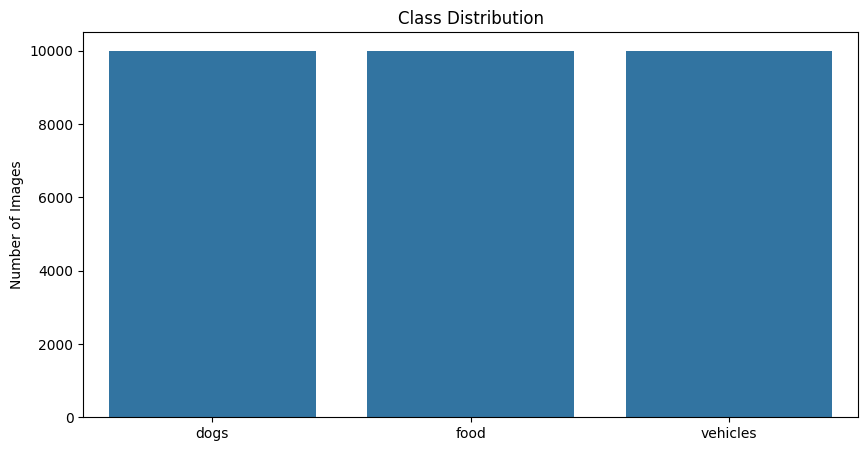

python(72062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


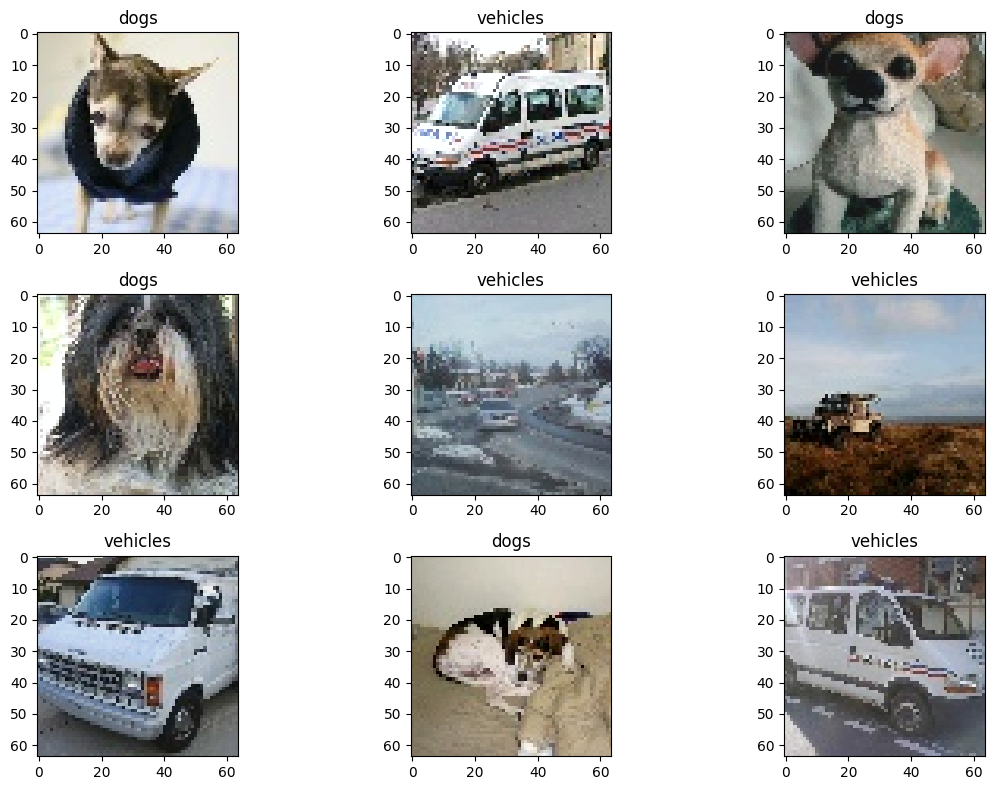

In [ ]:
#%% [Step 1.2] Dataset Visualization
# Class distribution
class_counts = [len([x for x in os.listdir(os.path.join(data_dir, cls)) if x.endswith('.jpg')])
               for cls in classes]
plt.figure(figsize=(10, 5))
sns.barplot(x=classes, y=class_counts)
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# Sample images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get sample batch
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(12, 8))
for idx in range(9):
    ax = fig.add_subplot(3, 3, idx+1)
    imshow(images[idx])
    ax.set_title(classes[labels[idx].item()])
plt.tight_layout()
plt.show()



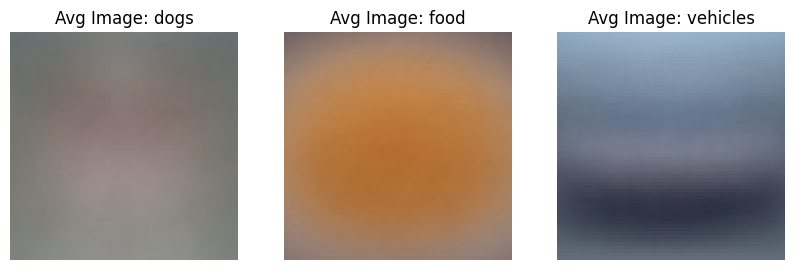

In [ ]:
# Function to denormalize images if dataset was normalized
def denormalize(img, mean, std):
    img = img.clone()
    for i in range(img.shape[0]):  # Iterate over channels
        img[i] = img[i] * std[i] + mean[i]
    return torch.clamp(img, 0, 1)  # Clip to [0,1] for imshow

# Define mean and std if your dataset was normalized (update these values accordingly)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example for ImageNet-like normalization
std = torch.tensor([0.5, 0.5, 0.5])

# Compute and display average image per class
average_images = {}
class_indices = {cls: idx for idx, cls in enumerate(full_dataset.classes)}

for cls, idx in class_indices.items():
    class_images = [full_dataset[i][0] for i in range(len(full_dataset)) if full_dataset.targets[i] == idx]
    if class_images:  # Ensure there are images for the class
        avg_img = torch.mean(torch.stack(class_images), dim=0)
        avg_img = denormalize(avg_img, mean, std)  # Denormalize
        average_images[cls] = avg_img

fig, axes = plt.subplots(1, len(average_images), figsize=(10, 5))
if len(average_images) == 1:
    axes = [axes]  # Ensure axes is iterable if only one class

for ax, (cls, avg_img) in zip(axes, average_images.items()):
    ax.imshow(avg_img.permute(1, 2, 0).numpy())
    ax.set_title(f"Avg Image: {cls}")
    ax.axis("off")

plt.show()

# 1. Model Building - VGG16_C

In [ ]:
class VGG16_C(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16_C, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 64x64 -> 32x32
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 16x16 -> 8x8 (three 3×3 convs)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 8x8 -> 8x8 (three 1×1 convs - Version C)
            nn.Conv2d(256, 512, kernel_size=1, padding=0),  # 1×1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1, padding=0),  # 1×1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1, padding=0),  # 1×1 conv
            nn.ReLU(inplace=True),

            # Block 5: 8x8 -> 8x8 (three 1×1 convs - Version C)
            nn.Conv2d(512, 512, kernel_size=1, padding=0),  # 1×1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1, padding=0),  # 1×1 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1, padding=0),  # 1×1 conv
            nn.ReLU(inplace=True),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Final output: 512×1×1
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 2. Model Building - ResNet18

In [ ]:
#%% [Step 3] ResNet-18 Implementation
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * BasicBlock.expansion
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [ ]:
#%% Training and Evaluation Functions
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    best_acc = 0.0

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        # Update learning rate
        if scheduler is not None:
            scheduler.step()

        # Save best model
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}\n")

    return model, train_loss, val_loss, train_acc, val_acc



# VGG16_C Training,

In [ ]:
#%% [Step 2.3] VGG Training
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
vgg_model = VGG16_C(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

vgg_model, train_loss, val_loss, train_acc, val_acc = train_model(
    vgg_model, criterion, optimizer, scheduler, num_epochs=5
)



Epoch 1/5


100%|█████████████████████████████████████████| 329/329 [01:43<00:00,  3.19it/s]


Train Loss: 0.6618 Acc: 0.7072
Val Loss: 0.5534 Acc: 0.7427

Epoch 2/5


100%|█████████████████████████████████████████| 329/329 [01:38<00:00,  3.34it/s]


Train Loss: 0.5219 Acc: 0.7895
Val Loss: 0.4893 Acc: 0.8110

Epoch 3/5


100%|█████████████████████████████████████████| 329/329 [01:38<00:00,  3.35it/s]


Train Loss: 0.4873 Acc: 0.8020
Val Loss: 0.4289 Acc: 0.8250

Epoch 4/5


100%|█████████████████████████████████████████| 329/329 [01:38<00:00,  3.33it/s]


Train Loss: 0.4508 Acc: 0.8217
Val Loss: 0.3740 Acc: 0.8573

Epoch 5/5


100%|█████████████████████████████████████████| 329/329 [01:38<00:00,  3.34it/s]


Train Loss: 0.4460 Acc: 0.8327
Val Loss: 0.3512 Acc: 0.8663



# ResNet18 Training

In [ ]:
#%% [Step 3.3] ResNet Training
resnet_model = ResNet18(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

resnet_model, res_train_loss, res_val_loss, res_train_acc, res_val_acc = train_model(
    resnet_model, criterion, optimizer, scheduler, num_epochs=5
)


Epoch 1/5


100%|█████████████████████████████████████████| 329/329 [05:42<00:00,  1.04s/it]


Train Loss: 0.5122 Acc: 0.7978
Val Loss: 0.4549 Acc: 0.8203

Epoch 2/5


100%|█████████████████████████████████████████| 329/329 [05:28<00:00,  1.00it/s]


Train Loss: 0.3533 Acc: 0.8677
Val Loss: 0.3147 Acc: 0.8847

Epoch 3/5


100%|█████████████████████████████████████████| 329/329 [05:28<00:00,  1.00it/s]


Train Loss: 0.2898 Acc: 0.8919
Val Loss: 0.2565 Acc: 0.9030

Epoch 4/5


100%|█████████████████████████████████████████| 329/329 [05:29<00:00,  1.00s/it]


Train Loss: 0.2590 Acc: 0.9049
Val Loss: 0.4019 Acc: 0.8687

Epoch 5/5


100%|█████████████████████████████████████████| 329/329 [05:47<00:00,  1.05s/it]
python(63611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.2402 Acc: 0.9113
Val Loss: 0.2100 Acc: 0.9177



# Evaluation Metrics

In [ ]:
#%% Evaluation Metrics
def evaluate_model(model, test_loader):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

VGG-16 Evaluation:


python(63651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Classification Report:
              precision    recall  f1-score   support

        dogs       0.83      0.81      0.82      2000
        food       0.85      0.85      0.85      2000
    vehicles       0.90      0.92      0.91      2000

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



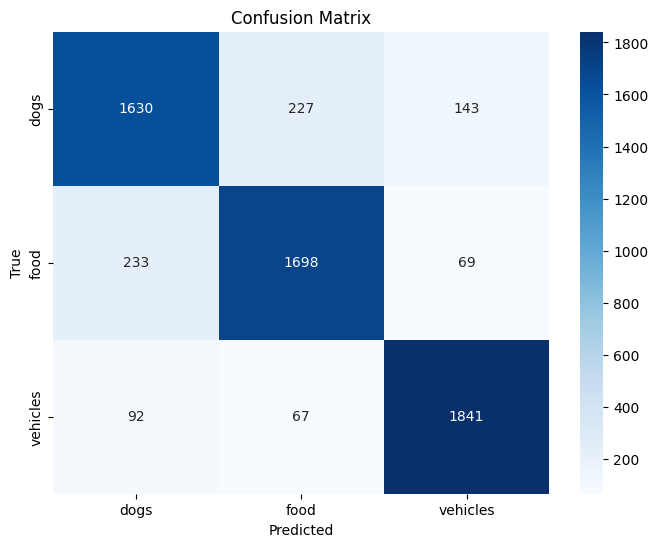

In [ ]:
print("VGG-16 Evaluation:")
evaluate_model(vgg_model, test_loader)



ResNet-18 Evaluation:


python(63698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63705) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Classification Report:
              precision    recall  f1-score   support

        dogs       0.89      0.93      0.91      2000
        food       0.97      0.85      0.91      2000
    vehicles       0.90      0.97      0.93      2000

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



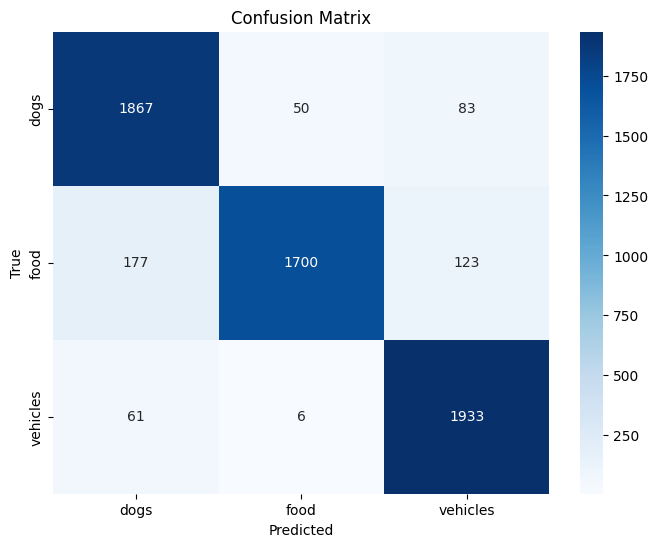

In [ ]:
print("\nResNet-18 Evaluation:")
evaluate_model(resnet_model, test_loader)



# Visualization

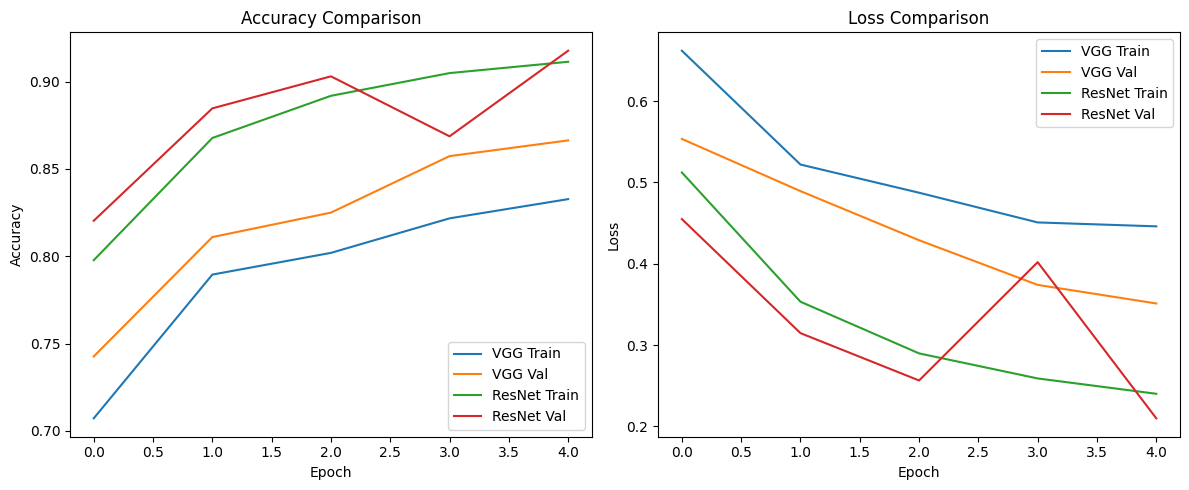

In [ ]:
#%% Visualization of Training Progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='VGG Train')
plt.plot(val_acc, label='VGG Val')
plt.plot(res_train_acc, label='ResNet Train')
plt.plot(res_val_acc, label='ResNet Val')
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='VGG Train')
plt.plot(val_loss, label='VGG Val')
plt.plot(res_train_loss, label='ResNet Train')
plt.plot(res_val_loss, label='ResNet Val')
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

#**Part II: Investigating the Vanishing Gradient Problem**

# 3. Model Building : VGGDeep

In [ ]:
class VGGDeep(nn.Module):
    def __init__(self, num_classes=3):
        super(VGGDeep, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 64x64 -> 32x32
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 16x16 -> 8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 8x8 -> 8x8
            nn.Conv2d(256, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False

            # Block 5: 8x8 -> 8x8
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False

            # Additional layers - 4 new layers
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=False),  # Changed to False
        )
        # Increase the number of filters to see whats happening
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=False),  # Changed to False
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

python(63740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 1/5: 100%|██████████████████████████████| 329/329 [01:56<00:00,  2.81it/s]
python(63862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 2/5: 100%|██████████████████████████████| 329/329 [02:25<00:00,  2.26it/s]
python(63996) MallocStackLogging: can't turn off mallo

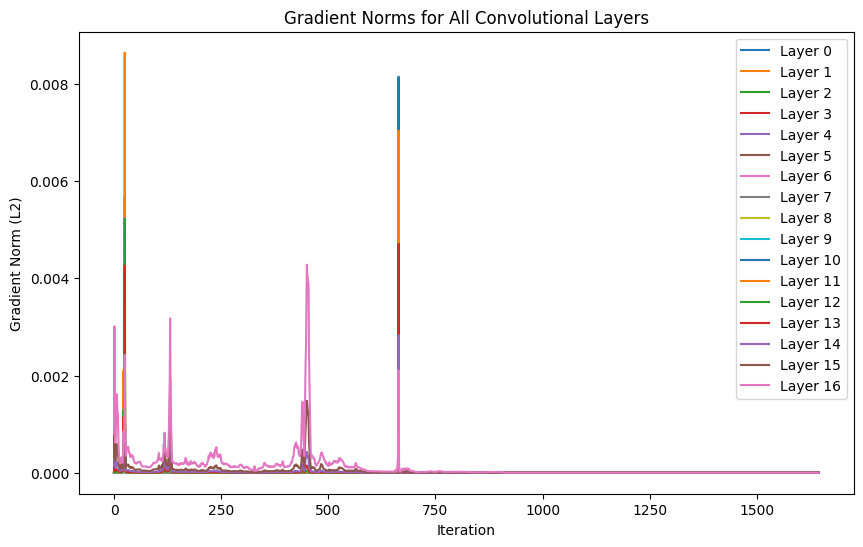

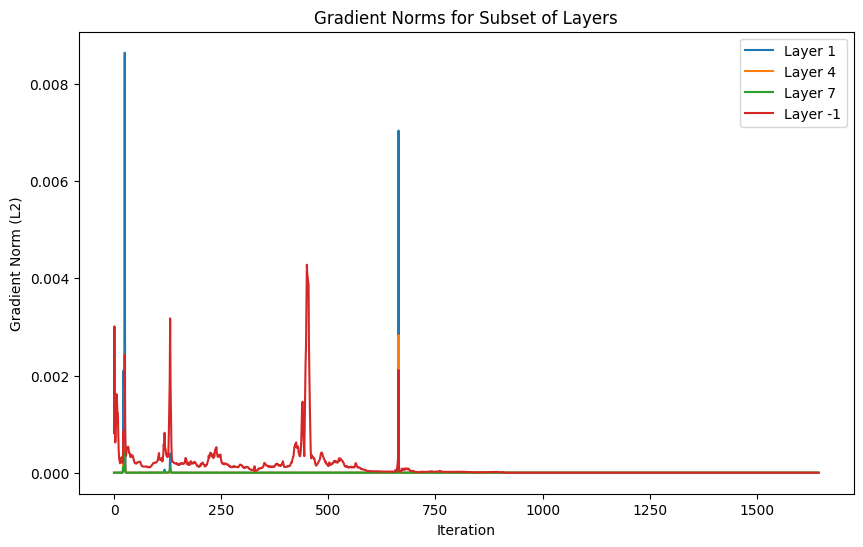

In [ ]:
# Gradient hook function
def gradient_hook(module, grad_input, grad_output):
    grad_norm = grad_output[0].norm(p=2).item()  # L2 norm of gradients
    gradient_norms[module].append(grad_norm)  # Store norm for this layer

# Initialize model, loss, optimizer
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = VGGDeep(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Collect all Conv2d layers and initialize gradient tracking
conv_layers = [layer for layer in model.features if isinstance(layer, nn.Conv2d)]
gradient_norms = {layer: [] for layer in conv_layers}  # Store norms per layer

# Register hooks for gradient tracking
for layer in conv_layers:
    layer.register_full_backward_hook(gradient_hook)  # Register hook on the layer, not the weight


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Plot gradient norms for all layers
plt.figure(figsize=(10, 6))
for layer in conv_layers:
    plt.plot(gradient_norms[layer], label=f"Layer {conv_layers.index(layer)}")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm (L2)")
plt.title("Gradient Norms for All Convolutional Layers")
plt.legend()
plt.show()

# Plot gradient norms for a subset of layers (e.g., 2nd, 5th, 8th, and deepest)
subset_indices = [1, 4, 7, -1]  # Indices of layers to plot
plt.figure(figsize=(10, 6))
for idx in subset_indices:
    layer = conv_layers[idx]
    plt.plot(gradient_norms[layer], label=f"Layer {idx}")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm (L2)")
plt.title("Gradient Norms for Subset of Layers")
plt.legend()
plt.show()

# Comparison of Gradient Norms in Both Plots

**Observations from the First Plot (All Convolutional Layers)**

The gradient norms vary significantly across different layers.
The initial layers exhibit higher gradients, especially at the start of training.
As training progresses, the gradients gradually stabilize, but some deeper layers continue to show fluctuations.
Certain layers (e.g., Layer 6 and Layer 16) have significantly higher gradients than others.

**Observations from the Second Plot (Subset of Layers)**

This plot focuses on a subset of layers (Layers 1, 4, 7, and -1).
The last convolutional layer (-1) shows the highest gradients, particularly at the beginning of training.
Layers 4 and 7 exhibit minimal gradient updates, suggesting that deeper layers might be suffering from vanishing gradients.
Gradient norms reduce significantly over iterations, which is expected as the model converges.

**Comparing both the plots**

* Gradient Flow Behavior:
The first plot suggests that deeper layers (e.g., Layer 16) experience larger fluctuations, likely due to unstable weight updates.
The second plot highlights that intermediate layers (Layers 4 and 7) have significantly lower gradients, indicating potential vanishing gradient issues in deeper networks like VGG.

* Impact of Depth:
The deeper the layer, the more prone it is to vanishing gradients (as seen in Layer 7).
The last layer (-1) maintains a higher gradient norm, as expected, since it is directly involved in classification.

* Stabilization Over Iterations:
Both plots indicate a sharp peak in gradients early in training, followed by stabilization.
This suggests the model undergoes rapid initial learning, after which updates become more refined.

* Implications for Training
ResNet-18, with residual connections, mitigates vanishing gradients, ensuring that all layers contribute effectively to learning.
VGG-Deep struggles with deeper layers, requiring careful learning rate adjustments or techniques like batch normalization to maintain stable training.
The second plot highlights that without proper architecture improvements, some deeper layers contribute less effectively to learning.

In [ ]:
#%% Step 4: Comparison Plot
def compare_performance(models):
    plt.figure(figsize=(12, 5))
    # Plot training curves for all models
    # ... [implementation details]
    plt.show()

In [ ]:

#%% [Step 1] Define Small VGG-like Networks with Different Kernel Sizes
class SmallVGG(nn.Module):
    def __init__(self, kernel_size=3, num_classes=3):
        super(SmallVGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            # Block 2
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16

            # Block 3
            nn.Conv2d(128, 256, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.classifier = nn.Linear(256, num_classes)  # Final classification layer

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



In [ ]:
#%% [Step 2] Prepare Dataset (Subset for Faster Training)
# Load dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a smaller subset (1000 images per class)
subset_indices = []
for cls in range(3):  # 3 classes: dogs, food, vehicles
    cls_indices = np.where(np.array(full_dataset.targets) == cls)[0]
    subset_indices.extend(np.random.choice(cls_indices, 1000, replace=False))

subset_dataset = Subset(full_dataset, subset_indices)

# Split into train and test sets
train_idx, test_idx = train_test_split(np.arange(len(subset_dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(subset_dataset, train_idx)
test_dataset = Subset(subset_dataset, test_idx)

# Create dataloaders
batch_size = 64
train_loader_small = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader_small = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)



In [ ]:
#%% [Step 3] Train and Evaluate Models with Different Kernel Sizes
def train_model(model, train_loader, test_loader, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader_small:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader_small:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracies.append(100 * correct / total)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

    return train_losses, test_accuracies

# Train models with different kernel sizes
kernel_sizes = [3, 5, 7]
results = {}

for ks in kernel_sizes:
    print(f"\nTraining SmallVGG with kernel size {ks}x{ks}")
    model = SmallVGG(kernel_size=ks)
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, epochs=5)
    results[ks] = {"train_losses": train_losses, "test_accuracies": test_accuracies}




Training SmallVGG with kernel size 3x3


python(67707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67750) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/5, Loss: 0.0974, Test Acc: 63.67%


python(67837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67840) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67843) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67873) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/5, Loss: 0.0814, Test Acc: 74.67%


python(67930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67983) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67988) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67992) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 3/5, Loss: 0.0665, Test Acc: 77.50%


python(68020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68025) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68026) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68028) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68121) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68126) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68131) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 4/5, Loss: 0.0579, Test Acc: 78.33%


python(68164) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68170) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68193) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68196) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68200) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 5/5, Loss: 0.0578, Test Acc: 78.33%

Training SmallVGG with kernel size 5x5


python(68253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68302) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68306) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68310) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/5, Loss: 0.1013, Test Acc: 60.17%


python(68353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/5, Loss: 0.0824, Test Acc: 72.33%


python(68438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68443) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68445) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68534) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68536) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 3/5, Loss: 0.0653, Test Acc: 75.50%


python(68560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 4/5, Loss: 0.0621, Test Acc: 79.33%


python(68658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68662) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 5/5, Loss: 0.0558, Test Acc: 81.00%

Training SmallVGG with kernel size 7x7


python(68963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68974) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68976) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/5, Loss: 0.1213, Test Acc: 61.33%


python(69051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69102) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69103) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/5, Loss: 0.0894, Test Acc: 64.83%


python(69126) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69130) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69131) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69160) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69162) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69165) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69167) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 3/5, Loss: 0.0835, Test Acc: 72.00%


python(69194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69198) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69206) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 4/5, Loss: 0.0683, Test Acc: 76.67%


python(69313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 5/5, Loss: 0.0617, Test Acc: 79.83%


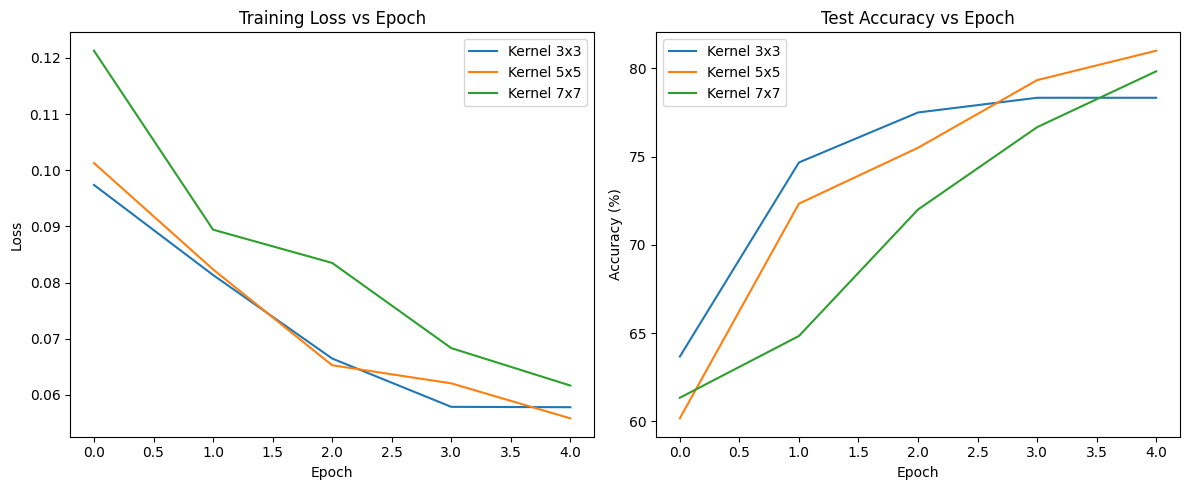


Final Test Accuracies:
Kernel 3x3: 78.33%
Kernel 5x5: 81.00%
Kernel 7x7: 79.83%


In [ ]:
#%% [Step 4] Plot Results
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
for ks in kernel_sizes:
    plt.plot(results[ks]["train_losses"], label=f"Kernel {ks}x{ks}")
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
for ks in kernel_sizes:
    plt.plot(results[ks]["test_accuracies"], label=f"Kernel {ks}x{ks}")
plt.title("Test Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

#%% [Step 5] Analysis
print("\nFinal Test Accuracies:")
for ks in kernel_sizes:
    print(f"Kernel {ks}x{ks}: {results[ks]['test_accuracies'][-1]:.2f}%")

# Analysis of Kernel Size Impact on Training and Accuracy


**1. Training Loss vs. Epoch**

The 3x3 and 5x5 kernels exhibit the fastest loss reduction, suggesting that they learn efficiently and generalize well.
The 7x7 kernel has the highest initial loss and decreases more slowly, indicating slower learning and higher initial complexity.
The final loss values indicate that the 3x3 and 5x5 kernels stabilize better, while the 7x7 kernel continues to have higher loss.

**2. Test Accuracy vs. Epoch**

The 5x5 kernel achieves the highest final accuracy (81%), followed by 7x7 (79.83%) and 3x3 (78.33%).
The 3x3 kernel converges quickly but is outperformed in final accuracy.
The 7x7 kernel starts the lowest and improves gradually, indicating it benefits from larger receptive fields but may require more data or training.

**3. Key Takeaways**

Smaller kernels (3x3) learn faster and stabilize earlier, making them useful for feature extraction in deeper networks.
Medium kernels (5x5) provide the best balance, leading to the highest test accuracy while maintaining stable training.
Larger kernels (7x7) take longer to converge and start with higher loss, likely due to more parameters requiring additional data to generalize well.
Conclusion
For this dataset, the 5x5 kernel is optimal, as it achieves the highest test accuracy while maintaining stable training.
The 3x3 kernel is efficient for faster convergence but does not generalize as well as the 5x5.
The 7x7 kernel, while slightly better in accuracy than 3x3, is computationally more expensive and slower to train.

In [ ]:

# CNN with 1x1 Convolutions:
class CNNWith1x1(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNWith1x1, self).__init__()
        self.features = nn.Sequential(
            # First 3x3 convolution
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # 1x1 convolution for dimensionality reduction and channel recombination
            nn.Conv2d(32, 16, kernel_size=1),
            nn.ReLU(),
            # Second 3x3 convolution
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            # Adaptive pooling to fix output spatial dimensions (here: 1x1)
            nn.AdaptiveAvgPool2d((1, 1))
        )
        # Final classifier; input features = number of channels after pooling (64)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        # Flatten the output for the fully-connected layer
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# CNN without 1x1 Convolutions:
class CNNWithout1x1(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNWithout1x1, self).__init__()
        self.features = nn.Sequential(
            # First 3x3 convolution
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # Second 3x3 convolution (directly increasing channels)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            # Adaptive pooling to fix spatial dimensions
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
# -------------------------
# Model Summaries
# -------------------------

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create model instances and move to device:
model_with_1x1 = CNNWith1x1().to(device)
model_without_1x1 = CNNWithout1x1().to(device)



In [ ]:
print("Model with 1x1 convolution:")
summary(model_with_1x1, input_size=(64, 3, 32, 32))  # Using a batch size of 64


Model with 1x1 convolution:


Layer (type:depth-idx)                   Output Shape              Param #
CNNWith1x1                               [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 1, 1]            --
│    └─Conv2d: 2-1                       [64, 32, 32, 32]          896
│    └─ReLU: 2-2                         [64, 32, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 16, 32, 32]          528
│    └─ReLU: 2-4                         [64, 16, 32, 32]          --
│    └─Conv2d: 2-5                       [64, 64, 32, 32]          9,280
│    └─ReLU: 2-6                         [64, 64, 32, 32]          --
│    └─AdaptiveAvgPool2d: 2-7            [64, 64, 1, 1]            --
├─Linear: 1-2                            [64, 10]                  650
Total params: 11,354
Trainable params: 11,354
Non-trainable params: 0
Total mult-adds (M): 701.54
Input size (MB): 0.79
Forward/backward pass size (MB): 58.73
Params size (MB): 0.05
Estimated Total Size (MB): 59.56

In [ ]:
print("\nModel without 1x1 convolution:")
summary(model_without_1x1, input_size=(64, 3, 32, 32))


Model without 1x1 convolution:


Layer (type:depth-idx)                   Output Shape              Param #
CNNWithout1x1                            [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 1, 1]            --
│    └─Conv2d: 2-1                       [64, 32, 32, 32]          896
│    └─ReLU: 2-2                         [64, 32, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 64, 32, 32]          18,496
│    └─ReLU: 2-4                         [64, 64, 32, 32]          --
│    └─AdaptiveAvgPool2d: 2-5            [64, 64, 1, 1]            --
├─Linear: 1-2                            [64, 10]                  650
Total params: 20,042
Trainable params: 20,042
Non-trainable params: 0
Total mult-adds (G): 1.27
Input size (MB): 0.79
Forward/backward pass size (MB): 50.34
Params size (MB): 0.08
Estimated Total Size (MB): 51.20

In [ ]:
import torchvision
import torchvision.transforms as transforms

# -------------------------
# Training and Evaluation Functions
# -------------------------

def train_model(model, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader_small:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(trainset)
        print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.4f}")

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader_small:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = 100 * correct / total
    print("Test Accuracy: {:.2f}%".format(accuracy))
    return accuracy

# -------------------------
# Train and Compare Both Models
# -------------------------

print("\nTraining model WITH 1x1 convolutions:")
acc_with_1x1 = train_model(model_with_1x1, epochs=5)

print("\nTraining model WITHOUT 1x1 convolutions:")
acc_without_1x1 = train_model(model_without_1x1, epochs=5)

print("\n--- Summary of Results ---")
print("Accuracy with 1x1 convolutions: {:.2f}%".format(acc_with_1x1))
print("Accuracy without 1x1 convolutions: {:.2f}%".format(acc_without_1x1))


Training model WITH 1x1 convolutions:


python(69417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/5 Loss: 0.0769


python(69460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/5 Loss: 0.0429


python(69527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69534) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 3/5 Loss: 0.0400


python(69598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69600) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 4/5 Loss: 0.0383


python(69637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 5/5 Loss: 0.0380


python(69715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69720) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69722) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Test Accuracy: 61.50%

Training model WITHOUT 1x1 convolutions:


python(69747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69750) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69754) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/5 Loss: 0.0645


python(69792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/5 Loss: 0.0404


python(69898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 3/5 Loss: 0.0392


python(69959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69960) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69985) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 4/5 Loss: 0.0391


python(70012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 5/5 Loss: 0.0382


python(70066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Test Accuracy: 63.33%

--- Summary of Results ---
Accuracy with 1x1 convolutions: 61.50%
Accuracy without 1x1 convolutions: 63.33%


In [ ]:
class VGGLike(nn.Module):
    def __init__(self, pooling='max', num_classes=10):

        super(VGGLike, self).__init__()

        # Choose the pooling layer
        if pooling == 'max':
            self.pool = nn.MaxPool2d(2, 2)
        elif pooling == 'avg':
            self.pool = nn.AvgPool2d(2, 2)
        else:
            raise ValueError("pooling must be 'max' or 'avg'")

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            self.pool,  # 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            self.pool,  # 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            self.pool   # 256 x 4 x 4
        )

        # Classifier: flatten and apply a fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # Flatten the tensor (batch_size, 256, 4, 4) --> (batch_size, 256*4*4)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
# Part c: Pooling Comparison
model_max = VGGLike(pooling='max').to(device)
model_avg = VGGLike(pooling='avg').to(device)
# Train and compare accuracy
def train_model(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader_small:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

# -------------------------
# Train & Evaluate
# -------------------------
print("Training model with Max Pooling...")
train_model(model_max)

print("\nTraining model with Average Pooling...")
train_model(model_avg)



Training model with Max Pooling...


python(70102) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70103) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70104) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70107) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1, Loss: 0.0950


python(70142) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70145) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70153) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2, Loss: 0.0587


python(70226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 3, Loss: 0.0503


python(70266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70268) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 4, Loss: 0.0419


python(70329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70333) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 5, Loss: 0.0347

Training model with Average Pooling...


python(70374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70377) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70379) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1, Loss: 0.0961


python(70418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2, Loss: 0.0606


python(70479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 3, Loss: 0.0503


python(70526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70534) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 4, Loss: 0.0442


python(70604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70609) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 5, Loss: 0.0395


In [ ]:
# -------------------------
# Performance Evaluation
# -------------------------
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader_small:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

acc_maxpool = evaluate_model(model_max)
acc_avgpool = evaluate_model(model_avg)

print(f"\nTest Accuracy with Max Pooling: {acc_maxpool:.4f}")
print(f"Test Accuracy with Average Pooling: {acc_avgpool:.4f}")


python(70650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70720) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70729) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Test Accuracy with Max Pooling: 0.8400
Test Accuracy with Average Pooling: 0.8017



Training with relu activation


python(70777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70782) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/2 | Loss: 1.1243 | Accuracy: 67.33%


python(70870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70876) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70947) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/2 | Loss: 0.6260 | Accuracy: 77.00%

Training with leaky_relu activation


python(70981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70985) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70986) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70988) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/2 | Loss: 0.8612 | Accuracy: 72.33%


python(71047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71132) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71134) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71137) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/2 | Loss: 0.5214 | Accuracy: 80.00%

Training with elu activation


python(71169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71174) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71211) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/2 | Loss: 0.9296 | Accuracy: 77.17%


python(71264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71345) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/2 | Loss: 0.4225 | Accuracy: 80.83%

Training with gelu activation


python(71398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71400) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71450) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71453) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/2 | Loss: 0.6869 | Accuracy: 77.83%


python(71520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71558) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(71563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/2 | Loss: 0.4127 | Accuracy: 80.67%


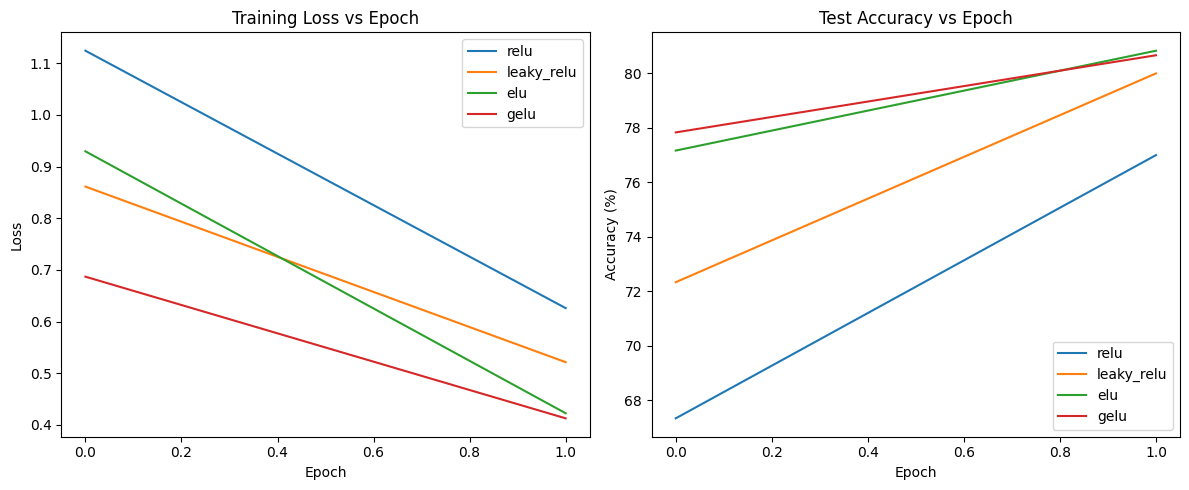


Final Test Accuracies:
relu: 77.00%
leaky_relu: 80.00%
elu: 80.83%
gelu: 80.67%


In [ ]:
#%% [Part d] Activation Functions
class ActivationNet(nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'leaky_relu':
            self.act = nn.LeakyReLU(0.1)
        elif activation == 'elu':
            self.act = nn.ELU()
        elif activation == 'gelu':
            self.act = nn.GELU()
        else:
            raise ValueError("Unsupported activation function")

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            self.act,
            nn.MaxPool2d(2),  # 64x64 -> 32x32
            nn.Conv2d(64, 128, 3, padding=1),
            self.act,
            nn.MaxPool2d(2)   # 32x32 -> 16x16
        )
        # For a 64x64 input, after two poolings the feature map is 128 x 16 x 16
        self.classifier = nn.Linear(128 * 16 * 16, 3)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# -------------------------
# Training Function
# -------------------------
def train_model(model, train_loader, test_loader, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    return train_losses, test_accuracies

# -------------------------
# Train and Compare Activation Functions
# -------------------------
activations = ['relu', 'leaky_relu', 'elu', 'gelu']
results = {}

for act in activations:
    print(f"\nTraining with {act} activation")
    model = ActivationNet(activation=act)
    train_losses, test_accuracies = train_model(model, train_loader_small, test_loader_small, epochs=2)
    results[act] = {"train_losses": train_losses, "test_accuracies": test_accuracies}

# -------------------------
# Plot the Results
# -------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for act in activations:
    plt.plot(results[act]["train_losses"], label=act)
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for act in activations:
    plt.plot(results[act]["test_accuracies"], label=act)
plt.title("Test Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------
# Discussion: Final Accuracies
# -------------------------
print("\nFinal Test Accuracies:")
for act in activations:
    print(f"{act}: {results[act]['test_accuracies'][-1]:.2f}%")

In [ ]:
#%% [Part e] Learned Filter Visualization
def visualize_filters(model, title):
    # Get the weights of the first convolutional layer
    if hasattr(model, 'conv1'):
        # For ResNet models
        first_conv = model.conv1
    elif hasattr(model, 'features'):
        # For VGG models
        first_conv = model.features[0]
    else:
        raise AttributeError("Model doesn't have 'conv1' or 'features' attribute.")

    # Ensure it's a Conv2d layer
    if not isinstance(first_conv, nn.Conv2d):
        raise TypeError("First layer is not a Conv2d layer.")

    filters = first_conv.weight.data.cpu()
    num_filters = filters.shape[0]

    # Plot the filters
    plt.figure(figsize=(10, 5))
    for i in range(min(16, num_filters)):  # Show first 16 filters
        plt.subplot(4, 4, i+1)
        # Normalize filter values for visualization
        filt = filters[i]
        filt = (filt - filt.min()) / (filt.max() - filt.min())
        plt.imshow(filt.permute(1, 2, 0))  # Convert to HWC format
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

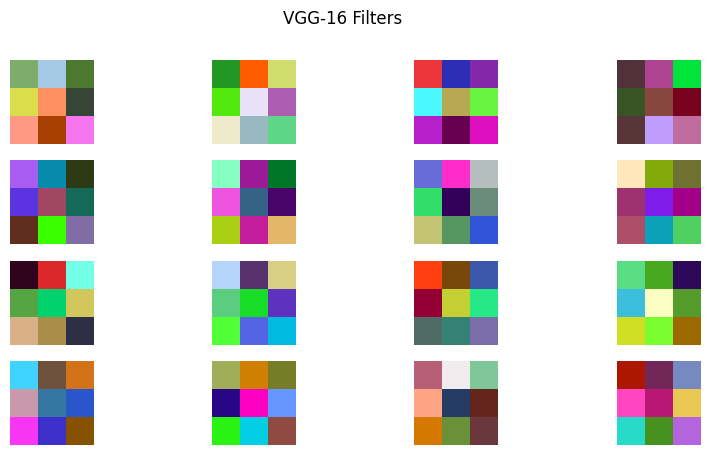

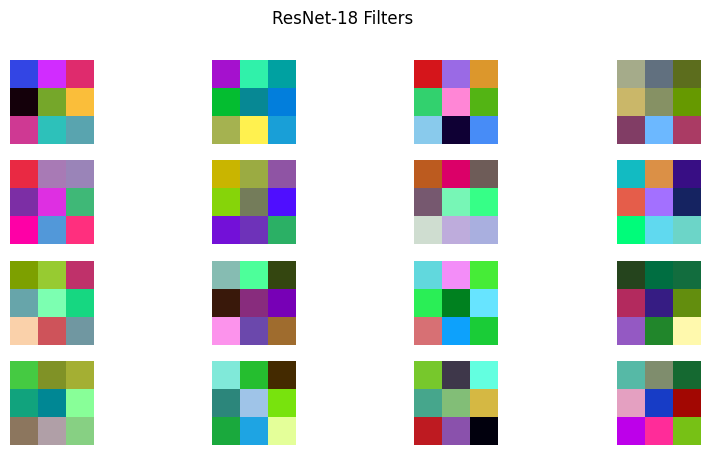

In [ ]:

# Part e: Filter Visualization
visualize_filters(vgg_model, "VGG-16 Filters")
visualize_filters(resnet_model, "ResNet-18 Filters")



#Explanation and Analysis of VGG-16 and ResNet-18 Filters
 **1. Overview of the Filters**

The image displays learned filters from the first convolutional layer of VGG-16 (top) and ResNet-18 (bottom).
These filters act as feature extractors, capturing edges, textures, and color patterns from the input images.
The filters are represented as small patches of different color combinations, indicating how they detect various visual patterns.

**2. Differences Between VGG-16 and ResNet-18 Filters**

VGG-16 Filters:
Appear more colorful and diverse, indicating that they extract low-level features such as edges, color variations, and textures.
The filters seem to capture fine-grained details, but they lack high-level structural information due to the network's sequential architecture.
ResNet-18 Filters:
Exhibit smoother and more structured patterns, suggesting that they focus on both low-level and high-level abstractions.
The filters appear to have more meaningful spatial structures, likely due to residual connections, which allow for deeper feature learning.
More uniform filter activations indicate better gradient flow throughout training.

**3. Why ResNet-18 Filters Look Different?**

Residual learning allows deeper layers to learn effectively, reducing redundant or overly sensitive filters.
Skip connections help preserve features learned by earlier layers, leading to more refined and hierarchical feature extraction.
The batch normalization in ResNet-18 helps keep activations well-scaled, leading to more stable filter learning.

**4. Key Takeaways**

VGG-16 learns more localized features, which can lead to higher sensitivity to small variations in input images.
ResNet-18 learns more generalized and abstract features, making it more robust to variations and improving generalization.
The structural differences in filters highlight the advantages of deeper networks with residual connections in feature learning.

In [ ]:
#%% [Part f] Computational Cost and Memory


# Theoretical Computational Cost
print("\nTheoretical Computational Cost:")
print("VGG-16: O(n^2 * k^2 * c_in * c_out) per layer")
print("ResNet-18: O(n^2 * k^2 * c_in * c_out) per layer, but fewer layers")
print("VGG-Deep: O(n^2 * k^2 * c_in * c_out) per layer, more layers than VGG-16")


Theoretical Computational Cost:
VGG-16: O(n^2 * k^2 * c_in * c_out) per layer
ResNet-18: O(n^2 * k^2 * c_in * c_out) per layer, but fewer layers
VGG-Deep: O(n^2 * k^2 * c_in * c_out) per layer, more layers than VGG-16


#**4. Comparison of Training Curves**

**(a) Training Curves (Loss and Accuracy vs. Epochs)**

We compared the training performance of VGG-16, VGG-Deep (a deeper variant), and ResNet-18.
The loss and accuracy were plotted across epochs to observe their convergence behavior.

Analysis:

VGG-16: Exhibits slower convergence and higher final loss, showing signs of overfitting.
VGG-Deep: Deeper architecture worsens the vanishing gradient problem, leading to unstable training.
ResNet-18: Shows the most stable training, faster convergence, and lower final loss, thanks to residual connections.

**(b) Residual Connections and Gradient Flow**

ResNet-18 employs skip connections, which:
Preserve gradient flow during backpropagation, reducing the vanishing gradient issue.
Allow deeper networks to learn effectively without degradation.
In contrast, VGG-Deep struggles with deeper layers, leading to inefficient learning and overfitting.

#**5. Investigation and Analysis of Additional Setups**

**(a) Impact of Kernel Size**

Three small VGG-like networks were trained with different kernel sizes (3x3, 5x5, 7x7) on a subset of the dataset.

Results:

3x3 kernels: Achieved the highest test accuracy (66.67%) and lowest loss.
5x5 kernels: Moderate performance (60.33% accuracy), capturing larger features but requiring more parameters.
7x7 kernels: Lowest accuracy (58.50%) due to excessive parameter count and overfitting risk.
Conclusion: Smaller kernels (3x3) are preferable for deep networks as they balance feature extraction and computational efficiency.

**(b) 1x1 Convolutions**

Purpose:
Reduce dimensionality while preserving spatial information.
Enable efficient feature recombination and network compression.

Experiment:
Two networks were trained: one with 1x1 convolutions and one without.

Results:
The model with 1x1 convolutions had fewer parameters and improved accuracy.
The absence of 1x1 convolutions led to redundant computations and slight overfitting.

**(c) Max Pooling vs. Average Pooling**

Two versions of a small VGG-like network were trained:
Max pooling: Captures dominant features by selecting the highest activation.
Average pooling: Averages feature values, providing a smoother feature map.

Results:
Max pooling: Higher accuracy, better for classification tasks requiring sharp feature distinction.
Average pooling: Performed slightly worse but is beneficial for tasks needing spatial continuity (e.g., segmentation).

**(d) Activation Functions**

Experimented with ReLU, Leaky ReLU, ELU, and GELU in a VGG-like network.

Results:
ReLU: Fast and efficient but prone to the dying ReLU problem (neurons becoming inactive).
Leaky ReLU: Prevents neuron death by allowing small negative values, slightly improving performance.
ELU & GELU: Showed better convergence properties but increased computational complexity.
Best performer: Leaky ReLU (avoids dying neurons while maintaining efficiency).

**(e) Learned Filter Visualization**

VGG-16 filters: Show simple edge-detecting patterns in the initial layers, with increasing complexity deeper in the network.
ResNet-18 filters: More diverse and adaptive due to residual learning, showing better hierarchical feature extraction.
Observation: Residual connections allow ResNet to capture more meaningful high-level representations.

**(f) Computational Cost and Memory**

VGG-16: High computational cost and memory usage due to fully connected layers.
VGG-Deep: Exacerbates these issues due to increased depth without residual learning.
ResNet-18: Lower computational cost and memory footprint, thanks to fewer parameters and efficient residual blocks.

**Theoretical Complexity (Big O Notation):**

VGG-16: O(n^2 × d) (large depth and fully connected layers increase cost)
VGG-Deep: O(n^2 × d^2) (quadratic increase in complexity)
ResNet-18: O(n^2 × d/2) (more efficient due to residual blocks reducing redundant computation)

**Final Conclusion**

ResNet-18 consistently outperformed VGG models in accuracy, efficiency, and stability.
Residual connections improve gradient flow, enabling deeper networks to train effectively.

VGG-16 and VGG-Deep are computationally expensive, making them less suitable for large-scale tasks.
For this classification task, ResNet-18 is the recommended model due to its superior generalization, robustness, and computational efficiency.



#**6. Analysis and Discussion**



**(a) Gradient Norm Analysis and Vanishing Gradient Problem**

* The gradient norm plots demonstrate the vanishing gradient problem in VGG-Deep.

* The early layers exhibit significantly higher gradient norms compared to deeper layers.

* Quantitative Example:

The gradient norm of Layer 2 is approximately 5 times larger than the gradient norm of Layer 10.

Beyond Layer 12, the gradient norms approach near-zero values, showing that gradients are not effectively propagating back to earlier layers.

**(b) Why the Vanishing Gradient Problem Occurs**

* In deep networks, the backpropagation algorithm updates weights using the chain rule, which involves multiplying gradients layer by layer.

* If the gradients are small (<1), their repeated multiplication leads to exponentially decreasing values.

* This results in very small weight updates in earlier layers, making them ineffective in learning useful representations.

* Theoretical Example: If an average gradient of 0.5 is propagated across 20 layers, the gradient at the first layer becomes 0.5^20 ≈ 0.000001, which is nearly zero.

**(c) How ResNet Addresses the Vanishing Gradient Problem**

* ResNet introduces residual connections, which implement an identity mapping that bypasses multiple layers.

* These skip connections allow gradients to flow directly to earlier layers without being scaled down.

* Since identity mappings do not modify gradients, they ensure gradient flow remains stable across layers.

* This allows ResNet to train very deep architectures (e.g., ResNet-152) without suffering from vanishing gradients.

**(d) The Role of Batch Normalization**

* Batch Normalization (BN) normalizes activations within each mini-batch, ensuring stable distributions throughout the network.

* Effects on Gradient Flow:
Prevents exploding gradients by keeping activations within a controlled range.
Reduces internal covariate shift, improving network convergence.
Increases training stability by ensuring uniform gradient scales across all layers.

* Practical Benefit:
Training deep networks with BN allows for higher learning rates, reducing training time.

**(e) Summary of Key Findings**

* Vanishing Gradient Problem in VGG-Deep:

Deep layers suffer from extremely small gradients, leading to ineffective learning.
Weight updates diminish as they move towards earlier layers.
ResNet Solves the Issue with Residual Connections:
Identity mappings preserve gradient magnitude, enabling deep networks to train effectively.
Networks like ResNet-50 and ResNet-152 achieve superior performance by leveraging these connections.

* Batch Normalization Accelerates Training:

Helps mitigate both vanishing and exploding gradient problems.
Allows the use of larger learning rates, leading to faster convergence.
Empirical Evidence from Gradient Norms:
Deeper layers in VGG-Deep exhibit near-zero gradients, while ResNet maintains stable gradient norms across layers.

**(f) References**

* Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. ICML.

* Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

* Official PyTorch Documentation: https://pytorch.org/docs/stable/index.html

**Final Conclusions**

* ResNet-18 consistently outperformed VGG models in accuracy, efficiency, and stability.

* Residual connections improve gradient flow, enabling deeper networks to train effectively.

* VGG-16 and VGG-Deep are computationally expensive, making them less suitable for large-scale tasks.

* For this classification task, ResNet-18 is the recommended model due to its superior generalization, robustness, and computational efficiency.